<a href="https://colab.research.google.com/github/theostoican/MastersThesis/blob/main/training_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import copy
import csv
import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib

# Various modelling parameters

In [ ]:
#N is batch size; D_in is input dimension;
#H is the dimension of the hidden layer; D_out is output dimension.
N, D_in, H_teacher, H_student, D_out = 1, 2, 4, 5, 1
num_experiments = 1

# Dataset creation

In [ ]:
def construct_dataset():
  data = []
  for y in np.arange(-5, 5.1, .25):
    for x in np.arange(-5, 5.1, .25):
      data.append([x, y])
  return data

data = torch.Tensor(construct_dataset()) 
print(len(construct_dataset()))

1681


# Models

In [ ]:
class TeacherNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(TeacherNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[0.6, -0.5, -0.2, 0.1], [0.5, 0.5, -0.6, -0.6]]), 0, 1))
    self.linear2.weight = torch.nn.Parameter(torch.transpose(torch.Tensor([[1], [-1], [1], [-1]]), 0, 1))
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [ ]:
class StudentNetwork(nn.Module):
  def __init__(self, D_in, H, D_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(StudentNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    nn.init.xavier_uniform_(self.linear1.weight)
    nn.init.xavier_uniform_(self.linear2.weight)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

# Generation of the labels based on the teacher model.

In [ ]:
teacher_model = TeacherNetwork(D_in, H_teacher, D_out)
y_labels = teacher_model(data).detach()

# Training helper method

In [ ]:
def train(model, x, y_labels, N = 1000, Ninner = 10**3, Nstart = 10,
          maxtime = 10 ** 3, nlopt_threshold = 1e-7,
          collect_history = True):
  optimizer = torch.optim.Adam(model.parameters()) #, lr=0.0001)
  loss_fn = nn.MSELoss()
  loss_vals = []
  trace = []
  if collect_history:
    trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                  copy.deepcopy(model.linear2.weight.data.detach().numpy())))
  for i in range(N):
    loss_tmp = []
    for j in range(Ninner):
      y = model(x)
      loss = loss_fn(y, y_labels)
      loss_grad = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
      loss_tmp.append(loss.item())
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      optimizer.step()
      if i == 0 and (j % Nstart == 0) and j > 0:
        loss_vals.append(np.mean(loss_tmp[j - Nstart : j]))
        if collect_history:
          trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                        copy.deepcopy(model.linear2.weight.data.detach().numpy())))
    loss_vals.append(np.mean(loss_tmp))
    if collect_history:
      trace.append((copy.deepcopy(model.linear1.weight.data.detach().numpy()),
                    copy.deepcopy(model.linear2.weight.data.detach().numpy())))
    # stopping criterion
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    print("Iteration: %d, loss: %s, gradient norm: %s" % (Ninner * i, np.mean(loss_tmp), torch.norm(g_vector)))
    if torch.norm(g_vector) <= 2e-6:
      break
  return loss_vals, trace

# Hessian evaluation helper

In [ ]:
# eval Hessian matrix
def eval_hessian(loss_grad, model):
    cnt = 0
    for g in loss_grad:
        g_vector = g.contiguous().view(-1) if cnt == 0 else torch.cat([g_vector, g.contiguous().view(-1)])
        cnt = 1
    grad_norm = torch.norm(g_vector)
    l = g_vector.size(0)
    hessian = torch.zeros(l, l)
    for idx in range(l):
        grad2rd = torch.autograd.grad(g_vector[idx], model.parameters(), create_graph=True)
        cnt = 0
        for g in grad2rd: 
            g2 = g.contiguous().view(-1) if cnt == 0 else torch.cat([g2, g.contiguous().view(-1)])
            cnt = 1
        hessian[idx] = g2
    hessian[:, idx] = g2
    return grad_norm.cpu().data.numpy(), hessian.cpu().data.numpy()

# Actual training and hessian computation

In [ ]:
student_model = StudentNetwork(D_in, H_student, D_out)
loss_vals, trace = train(student_model, data, y_labels)
last_loss_val = loss_vals[-1]

loss_grad = torch.autograd.grad(nn.MSELoss()(student_model(data), y_labels), student_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, student_model)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))

print('smallest eigenvalue: ', smallest_eigenvalue)

Iteration: 0, loss: 0.24548103631986304, gradient norm: tensor(0.0266)
Iteration: 1000, loss: 0.0010985530001344159, gradient norm: tensor(0.0023)
Iteration: 2000, loss: 0.0008695869455114007, gradient norm: tensor(0.0021)
Iteration: 3000, loss: 0.0006906465235515497, gradient norm: tensor(0.0022)
Iteration: 4000, loss: 0.00043477645091479644, gradient norm: tensor(0.0014)
Iteration: 5000, loss: 0.0002378844147606287, gradient norm: tensor(0.0005)
Iteration: 6000, loss: 0.00018665592998149804, gradient norm: tensor(0.0003)
Iteration: 7000, loss: 0.00017110209027305245, gradient norm: tensor(0.0002)
Iteration: 8000, loss: 0.000156422028405359, gradient norm: tensor(0.0002)
Iteration: 9000, loss: 0.00013900422349979636, gradient norm: tensor(0.0002)
Iteration: 10000, loss: 0.0001206938614413957, gradient norm: tensor(9.4079e-05)
Iteration: 11000, loss: 0.00010834092066943413, gradient norm: tensor(5.5420e-05)
Iteration: 12000, loss: 9.432427717547398e-05, gradient norm: tensor(0.0001)
It

# Plotting

In [ ]:
teacher_neurons_x = [0.6, -0.5, -0.2, 0.1]
teacher_neurons_y = [0.5, 0.5, -0.6, -0.6]

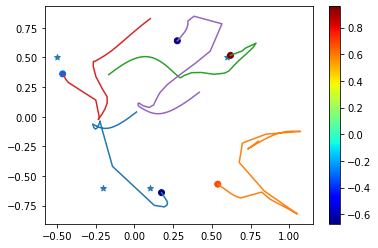

In [ ]:

neuron_0_w_x = []
neuron_0_w_y = []
neuron_0_a = []

neuron_1_w_x = []
neuron_1_w_y = []
neuron_1_a = []

neuron_2_w_x = []
neuron_2_w_y = []
neuron_2_a = []

neuron_3_w_x = []
neuron_3_w_y = []
neuron_3_a = []

neuron_4_w_x = []
neuron_4_w_y = []
neuron_4_a = []

for (inp_weights, out_weights) in trace:
  neuron_0_w_x.append(inp_weights[0][0])
  neuron_0_w_y.append(inp_weights[0][1])
  neuron_0_a.append(out_weights[0][0])

  neuron_1_w_x.append(inp_weights[1][0])
  neuron_1_w_y.append(inp_weights[1][1])
  neuron_1_a.append(out_weights[0][1])

  neuron_2_w_x.append(inp_weights[2][0])
  neuron_2_w_y.append(inp_weights[2][1])
  neuron_2_a.append(out_weights[0][2])

  neuron_3_w_x.append(inp_weights[3][0])
  neuron_3_w_y.append(inp_weights[3][1])
  neuron_3_a.append(out_weights[0][3])

  neuron_4_w_x.append(inp_weights[4][0])
  neuron_4_w_y.append(inp_weights[4][1])
  neuron_4_a.append(out_weights[0][4])

plt.plot(neuron_0_w_x, neuron_0_w_y)
plt.plot(neuron_1_w_x, neuron_1_w_y)
plt.plot(neuron_2_w_x, neuron_2_w_y)
plt.plot(neuron_3_w_x, neuron_3_w_y)
plt.plot(neuron_4_w_x, neuron_4_w_y)

plt.scatter(teacher_neurons_x, teacher_neurons_y, marker="*")

outgoing_weights = [neuron_0_a[-1], neuron_1_a[-1], neuron_2_a[-1], neuron_3_a[-1], neuron_4_a[-1]]
plt.scatter([neuron_0_w_x[-1], neuron_1_w_x[-1], neuron_2_w_x[-1], neuron_3_w_x[-1], neuron_4_w_x[-1]],
            [neuron_0_w_y[-1], neuron_1_w_y[-1], neuron_2_w_y[-1], neuron_3_w_y[-1], neuron_4_w_y[-1]],
            c = outgoing_weights,
            cmap=matplotlib.cm.jet)
plt.colorbar()

# Teacher's neurons
#[0.6, -0.5, -0.2, 0.1],
#[0.5, 0.5, -0.6, -0.6],

# Second order optimization

In [ ]:
!pip install dict_minimize
from dict_minimize.torch_api import minimize
from collections import OrderedDict

In [ ]:

class DummyNetwork(nn.Module):
  def __init__(self, D_in, H, D_out, w_in, w_out):
    """
    In the constructor we instantiate two nn.Linear modules and assign them as
    member variables.

    D_in: input dimension
    H: dimension of hidden layer
    D_out: output dimension of the first layer
    """
    super(DummyNetwork, self).__init__()
    self.linear1 = nn.Linear(D_in, H, bias=False) 
    self.linear2 = nn.Linear(H, D_out, bias=False)
    self.linear1.weight = torch.nn.Parameter(w_in)
    self.linear2.weight = torch.nn.Parameter(w_out)
  def forward(self, x):
    """
    In the forward function we accept a Variable of input data and we must
    return a Variable of output data. We can use Modules defined in the
    constructor as well as arbitrary operators on Variables.
    """
    h_sigmoid = torch.sigmoid(self.linear1(x))
    y_pred = self.linear2(h_sigmoid)
    return y_pred

In [ ]:
def d_loss(params):
    w_in, w_out = params["w_in"], params["w_out"]
    dummy_model = DummyNetwork(D_in, H_student, D_out, w_in, w_out)
    obj = nn.MSELoss()(dummy_model(data), y_labels)
    dw_in, dw_out = torch.autograd.grad(obj, dummy_model.parameters())
    d_obj = OrderedDict([("w_in", dw_in), ("w_out", dw_out)])
    return obj, d_obj

In [ ]:
params = OrderedDict([("w_in", torch.Tensor(trace[-1][0])), ("w_out", torch.Tensor(trace[-1][1]))])
lb_dict = OrderedDict([("w_in", torch.Tensor(trace[-1][0] - 1)), ("w_out", torch.Tensor(trace[-1][1] - 1))])
ub_dict = OrderedDict([("w_in", torch.Tensor(trace[-1][0] + 1)), ("w_out", torch.Tensor(trace[-1][1] + 1))])
print('old params: ',params)
# params = minimize(d_loss, params, method="", lb_dict = lb_dict, ub_dict = ub_dict,
#                   options={"disp": True , "maxiter": 10 ** 3}, tol=1e-8)
params = minimize(d_loss, params, method="SLSQP", lb_dict = lb_dict, ub_dict = ub_dict,
                  options={"disp": True , "maxiter": 10 ** 4}, tol=last_loss_val*1e-2)
print('new params: ',params)

OrderedDict([('w_in', tensor([[ 0.1746, -0.6405],
        [ 0.5376, -0.5689],
        [ 0.6200,  0.5173],
        [-0.4635,  0.3609],
        [ 0.2766,  0.6403]])), ('w_out', tensor([[-0.6722,  0.6866,  0.9590, -0.3062, -0.6673]]))])
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.626702269026282e-07
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
OrderedDict([('w_in', tensor([[ 0.1746, -0.6405],
        [ 0.5376, -0.5689],
        [ 0.6200,  0.5173],
        [-0.4635,  0.3609],
        [ 0.2766,  0.6403]], requires_grad=True)), ('w_out', tensor([[-0.6722,  0.6866,  0.9590, -0.3062, -0.6673]], requires_grad=True))])


# New smallest eigenvalue

In [ ]:
dummy_model = DummyNetwork(D_in, H_student, D_out, params["w_in"], params["w_out"])
print(nn.MSELoss()(dummy_model(data), y_labels))
loss_grad = torch.autograd.grad(nn.MSELoss()(dummy_model(data), y_labels), dummy_model.parameters(), create_graph=True)
grad_norm, hessian = eval_hessian(loss_grad, dummy_model)
print(hessian)
smallest_eigenvalue = np.min(np.linalg.eigvals(hessian))
print('new smallest eigenvelue:', smallest_eigenvalue)

tensor(2.6267e-07, grad_fn=<MseLossBackward0>)
[[ 1.97744012e-01  5.08105084e-02 -1.57506585e-01 -7.93312490e-02
  -1.21183477e-01  3.24766561e-02  7.52863660e-02  3.27221714e-02
   1.45985365e-01 -1.09020397e-02 -1.05642555e-02 -1.17316201e-01
  -1.73503757e-01  1.23071387e-01 -1.10244505e-01]
 [ 5.08105122e-02  7.73814768e-02 -7.93312490e-02 -1.02752209e-01
   3.24766561e-02 -8.97042006e-02  3.27221751e-02  5.36568202e-02
  -1.09020406e-02  5.92272058e-02  1.06434211e-01  5.88403791e-02
  -9.68245268e-02 -3.33285704e-02 -1.18424512e-01]
 [-1.57506585e-01 -7.93312490e-02  1.78587526e-01  1.35018915e-01
   7.28310123e-02 -1.31847744e-03 -8.13459232e-02 -6.01198450e-02
  -8.60339403e-02 -1.36302020e-02 -5.40331192e-02  5.27823269e-02
   1.69969931e-01 -7.44742900e-02  1.35939300e-01]
 [-7.93312490e-02 -1.02752194e-01  1.35018915e-01  1.68476075e-01
  -1.31847686e-03  7.95122012e-02 -6.01198412e-02 -8.57245401e-02
  -1.36302020e-02 -5.64389043e-02 -1.36252329e-01 -6.09476790e-02
   1.570